In [148]:
#implementation with batches
using Distributions
using GaussianProcess

# define proj for Stiefel manifold
function proj(U,V)
    return V-U*(U'*V+V'*U)/2
end

# define geod for Stiefel manifold
function geod(U,mom,t)
    n,r=size(U)
    A=U'*mom
    temp=[A -mom'*mom;eye(r) A]
    E=expm(t*temp)
    return [U mom]*E[:,1:r]*expm(-t*A)
end

function datawhitening(X) 
    for i = 1:size(X,2)   
        X[:,i] = (X[:,i] - mean(X[:,i]))/std(X[:,i])   
    end
    return X
end

function feature(X,n,sigmaRBF,seed)
    srand(seed)
    N,D=size(X)
    phi=Array(Float64,D,n,N)
    for i=1:N
        Z=randn(D,n)/sigmaRBF
    b=rand(D,n)
    x=repmat(X[i,:],n,1)
    phi[:,:,i]=sqrt(2/n)*cos(x'.*Z+b*2*pi)
    end
    return phi
end

#compute predictions from w,U,I
function pred(w,U,I,phitest)
    D,n,test_size=size(phitest)
    Q=length(w)
    r=size(U,2)
    temp=Array(Float64,D,r,test_size)
    # compute V st V[q,i]=prod_{k=1 to D}(temp[k,I[q,k],i])
    V=Array(Float64,Q,N)
    # compute fhat where fhat[i]=V[:,i]'w
    fhat=Array(Float64,test_size)
    for i=1:test_size
        for k=1:D
            temp[k,:,i]=phitest[k,:,i]*U[:,:,k] 
        end
        for q=1:Q
            V[q,i]=prod(diag(temp[:,vec(I[q,:]),i]))
        end
        fhat[i]=dot(V[:,i],w)
    end
    return fhat
end

function GPT_SGLDERMtest(phi::Array,y::Array,sigma::Real,sigma_w::Real,r::Integer,Q::Integer,m::Integer,epsw::Real,epsU::Real,maxepoch::Integer)
    # phi is the D by n by N array of features where phi[k,:,i]=phi^(k)(x_i)
    # sigma is the s.d. of the observed values
    # sigma_w is the s.d. for the Guassian prior on w
    # epsw,epsU are the epsilons for w and U resp.
    # maxepoch is the number of sweeps through whole dataset
    
    D,n,N=size(phi)
    numbatches=int(ceil(N/m))
    
    # initialise w,U^(k)
    w_store=Array(Float64,Q,numbatches*maxepoch)
    U_store=Array(Float64,n,r,D,numbatches*maxepoch)
    w=sigma_w*randn(Q)
    U=Array(Float64,n,r,D)
    for k=1:D
        Z=randn(r,n)
        U[:,:,k]=transpose(\(sqrtm(Z*Z'),Z)) #sample uniformly from V_{n,r}
    end
    
    # fix the random non-zero locations of w
    I=rand(DiscreteUniform(1, r),Q,D) 
    # so I_qd=index of dth dim of qth non-zero
    
    for epoch=1:maxepoch
        #randomly permute training data and divide into mini_batches of size m
        perm=randperm(N)
        phi=phi[:,:,perm]; y=y[perm];
        
        # run SGLD on w and SGLDERM on U
        for batch=1:numbatches
            # random samples for the stochastic gradient
            idx=(m*(batch-1)+1):min(m*batch,N)
            phi_batch=phi[:,:,idx]; y_batch=y[idx];
            batch_size=length(idx) #this is m except for last batch
            # compute <phi^(k)(x_i),U^(k)_{.l}> for all k,l,batch and store in temp
            temp=Array(Float64,D,r,batch_size)
            # compute V st V[q,i]=prod_{k=1 to D}(temp[k,I[q,k],i])
            V=Array(Float64,Q,batch_size)
            # compute fhat where fhat[i]=V[:,i]'w
            fhat=Array(Float64,batch_size)
            for i=1:batch_size
                for k=1:D
                    temp[k,:,i]=phi_batch[k,:,i]*U[:,:,k] 
                end
                for q=1:Q
                    V[q,i]=prod(diag(temp[:,vec(I[q,:]),i]))
                end
                fhat[i]=dot(V[:,i],w)
            end

            # now can compute gradw, the stochastic gradient of log post wrt w
            gradw=((N/batch_size)*V*(y_batch-fhat)-w)/(2*sigma_w^2)

            # compute U_phi[q,i,k]=expression in big brackets in (11)
            U_phi=Array(Float64,Q,batch_size,D)
            for k=1:D
                U_phi[:,:,k]=V./reshape(temp[k,I[:,k],:],Q,batch_size)
            end

            # now compute a_l^(k)(x_i) for l=1,...,r k=1,..,D and store in A
            A=zeros(r,D,batch_size)
            for i=1:batch_size
                for k=1:D
                    for l in unique(I[:,k])
                        index=findin(I[:,k],l) #I_l
                        A[l,:,i]=transpose(reshape(U_phi[index,i,:],length(index),D))*w[index] 
                    end
                end
            end

            # compute Psi as in (12)
            Psi=Array(Float64,n*r,batch_size,D)
            for i=1:batch_size
                for k=1:D
                    Psi[:,i,k]=kron(A[:,k,i],vec(phi_batch[k,:,i]))
                end
            end

            # can now compute gradU where gradU[:,:,k]=stochastic gradient of log post wrt U^(k)
            gradU=Array(Float64,n,r,D)
            for k=1:D
                gradU[:,:,k]=reshape((N/batch_size)*Psi[:,:,k]*(y[batch]-fhat)/(2*sigma^2),n,r)
            end

            # SGLD step on w
            w[:]+=epsw*gradw/2 +sqrt(2*epsw)*randn(Q)
            w_store[:,numbatches*(epoch-1)+batch]=w
            # SGLDERM step on U
            for k=1:D
                mom=proj(U[:,:,k],sqrt(epsU)*gradU[:,:,k]/2+randn(n,r))
                U[:,:,k]=geod(U[:,:,k],mom,sqrt(epsU))
                U_store[:,:,k,numbatches*(epoch-1)+batch]=U[:,:,k]
            end
        end
    end
    return w_store,U_store,I
end



sigmaRBF=1.4; sigma=0.2;
f=SECov(sigmaRBF,1)
gp=GP(0,f,4)
N=1000;
x1=rand(Uniform(0,50),N);
x2=rand(Uniform(30,100),N);
x3=rand(Uniform(1000,1020),N);
x4=rand(Uniform(50,100),N);
X=[x1 x2 x3 x4];
X=datawhitening(X);
y=GPrand(gp,X)+sigma*randn(N);
Xtrain=X[1:N/2,:]; ytrain=y[1:N/2];
Xtest=X[N/2+1:end,:]; ytest=y[N/2+1:end];



    
    

In [152]:
seed=17;
n=100;
phitrain=feature(Xtrain,n,sigmaRBF,seed);
phitest=feature(Xtest,n,sigmaRBF,seed);


In [153]:
r=10
Q=100
m=50
eps=0.001
maxepoch=3
w_store,U_store,I=GPT_SGLDERMtest(phitrain,ytrain,sigma,sigmaRBF,r,Q,m,eps,eps,maxepoch);

T=size(w_store,2);
fhat=pred(w_store[:,T],U_store[:,:,:,T],I,phitest);
norm(ytest-fhat)/sqrt(N/2)


0.9304727448810317

30


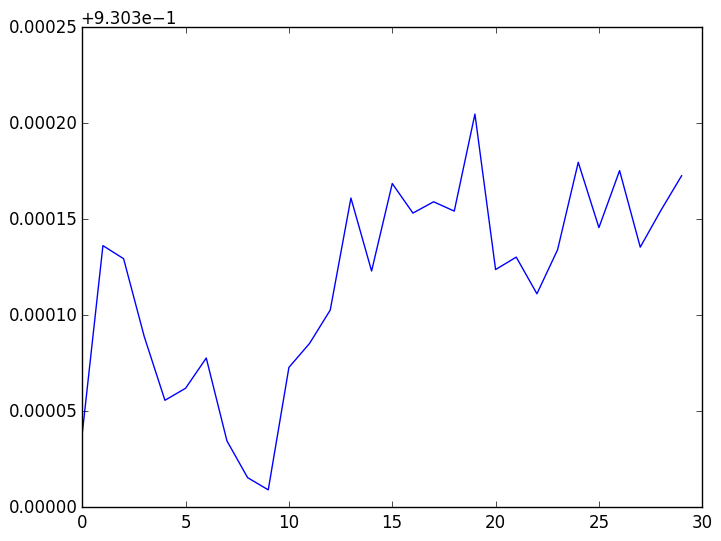

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7aa24be1d0>

In [186]:
using PyPlot
RMSE=Array(Float64,T);
for i=1:T
    fhat=pred(w_store[:,i],U_store[:,:,:,i],I,phitest);
    RMSE[i]=norm(ytest-fhat)/sqrt(N/2);
end
println(T)
plot(RMSE)

In [207]:
minimum([0,2,3])


0

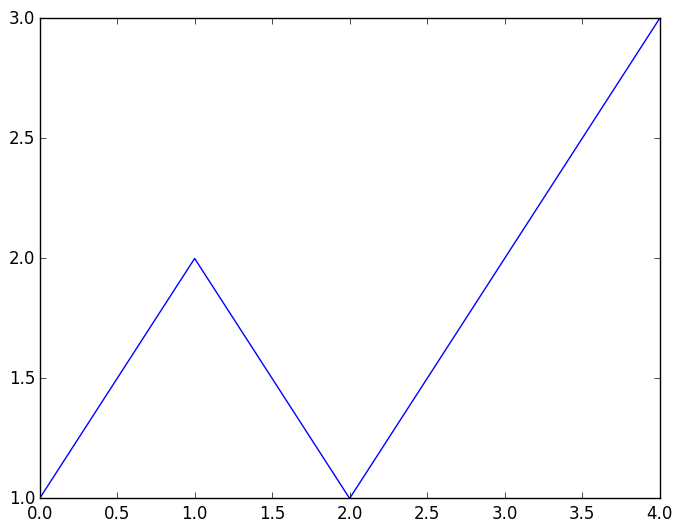

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7aa2711c50>

In [184]:
using PyPlot
plot([1,2,1,2,3])



In [200]:
digits(101,4,7)

7-element Array{Int64,1}:
 1
 1
 2
 1
 0
 0
 0

In [202]:
using Distributions
# rand(Distributions.DiscreteUniform(1,r),Q,D) 
r=2; Q=10; D=4
l=sample(0:(r^D-1),Q,replace=false)
I=Array(Int32,Q,D)
for q in 1:Q
    I[q,:]=digits(l[q],r,D)+1
end
println(I)


Int32[1 1 1 1
      2 1 2 2
      2 2 2 1
      2 1 1 1
      1 2 1 2
      2 2 1 1
      1 2 1 1
      1 1 2 2
      2 1 1 2
      2 1 2 1]
